# <font color="darkred">  Classification of Chest X-ray to detect Covid-19
 <br>
<br>

_20210382_       오정욱 <br>
_20226410_ Alexia Mallet

## <font color='burlywood'> Acknowledgment

This project has for objective to reproduce the network and results of COV19‑CNNet and COV19‑ResNet: Diagnostic Inference Engines for Early Detection of COVID‑19 -  Ayturk Keles, Mustafa Berk Keles, Ali Keles - (https://link.springer.com/content/pdf/10.1007/s12559-020-09795-5.pdf)

The Dataset used is called __COVIDx CXR-3__ and was downloaded from https://www.kaggle.com/datasets/andyczhao/covidx-cxr2?select=competition_test. <br> 
The credits for data collection belongs to _Wang, Linda and Lin, Zhong Qiu and Wong, Alexander, COVID-Net: a tailored deep convolutional neural network design for detection of COVID-19 cases from chest X-ray images, Scientific Reports, 2020_


## <font color='burlywood'> Table of contents
* I. [<font color='black'> Set up ](#paragraph1)
    * I.1. [<font color='dimgray'> Prerequisite](#subparagraph11)
    * I.2. [<font color='dimgray'> Library importation](#subparagraph12)
    * I.3. [<font color='dimgray'> Data importation](#subparagraph13)     
* II. [<font color='black'> Network implementation](#paragraph2)
    * II.1. [<font color='dimgray'> Implementation of Conv Block](#subparagraph21)
    * II.2. [<font color='dimgray'> Implementation of Identity Block](#subparagraph22)
    * II.3. [<font color='dimgray'> Implementation of ResNet Block](#subparagraph23)
    * II.4. [<font color='dimgray'> Implementation of the network COV19ResNet](#subparagraph24)

<a name="paragraph1"></a>
## <font color='burlywood'> I. Set up

<a name="subparagraph11"></a>
###  <font color='sienna'> I.1 -Prerequisite

In [4]:
# Mount the G drive 
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
# Setting the root directory 
root = '/gdrive/My Drive/CS492I/Project_Team23'

<a name="subparagraph12"></a>
###  <font color='sienna'> I.2 -Library importation

In [2]:
pip install torch 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [60]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import pandas as pd

<a name="subparagraph13"></a>
###  <font color='sienna'> I.3 -Data importation

Data consists of : 
- A training set composed of 29,979 Chest X-Ray images with names and a txt document with the patient id, the name of the image corresponding, the label (positive (15,994) or negative (13,992)) and the data source 
- A test set composed of 400 Chest X-Ray images with names and a txt document with the patient id, the name of the image corresponding, the label (positive (200) or negative (200)) and the data source 

In [2]:
# from torch.utils.data import DataLoader, Dataset
# import torchvision.transforms as T
# import torch
# import torch.nn as nn
# from torchvision.utils import make_grid
# from torchvision.utils import save_image
# from IPython.display import Image
# import matplotlib.pyplot as plt
# import numpy as np
# import random
# %matplotlib inline

In [5]:
path_train = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train.txt'
train_labels = pd.read_csv(path_train, sep=" ", header=None)
train_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source'] # Given in the data description 
train_labels=train_labels.drop(['PatientId', 'Data_Source'], axis=1 ) # Don't need the id of the patient or the data source 

path_test = 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test.txt'
test_labels = pd.read_csv(path_test, sep=" ", header=None)
test_labels.columns=['PatientId', 'File_Name', 'Class', 'Data_Source'] # Given in the data description 
test_labels=test_labels.drop(['PatientId', 'Data_Source'], axis=1 ) # Don't need the id of the patient or the data source 


In [6]:
train_labels

,File_Name,Class
0,ARDSSevere.png,negative
1,acute-respiratory-distress-syndrome-ards-1.jpg,negative
2,acute-respiratory-distress-syndrome-ards.jpg,negative
3,ards-secondary-to-tiger-snake-bite.png,negative
4,pneumocystis-pneumonia-2-PA.png,negative
...,...,...
29981,55204bb8-89fc-449d-8563-e91654abea9d.png,negative
29982,0f4b80b6-fd39-451f-aebf-7cdb1b655c0b.png,negative
29983,5fb64e85-62ef-4852-8ad1-f799015c8cc3.png,negative
29984,c57ad4fd-3aa8-4ae8-a262-7336360d8265.png,negative


In [83]:
def import_image(name, train = True) : 
    if (train) : 
        path_train = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_image/"
        return (torchvision.io.read_image(path_train + name))
    else : 
        path_test = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test_image/"
        return (torchvision.io.read_image(path_test + name))

In [100]:
class ImportData(Dataset):
    def __init__(self, df, train_bool = True):
        self.df = df
        self.train = train_bool

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        image = import_image(self.df["File_Name"][idx], self.train)
        label = self.df["Class"][idx]

        return image, label

In [101]:
train_data = ImportData(train_labels)
test_data = ImportData(test_labels)

In [99]:
train_labels["File_Name"][0]

'ARDSSevere.png'

In [86]:
train_data

In [4]:
# DATA_DIR = '../archive/train'
DATA_DIR = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_image"
X_train = np.load(DATA_DIR)
print(f"Shape of training data: {X_train.shape}")
print(f"Data type: {type(X_train)}")

PermissionError: [Errno 13] Permission denied: 'C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train_image'

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
train_dir = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/train"
train_dataloader = DataLoader(train_dir)
test_dir = "C:/Users/Alexia85/Documents/KAIST/Cours/CS491/Project/archive/test"
test_dataloader = DataLoader(test_dir)

<a name="paragraph2"></a>
## <font color='burlywood'> II. Network implementation

<a name="subparagraph21"></a>
###  <font color='sienna'> II.1 -Implementation of Conv Block

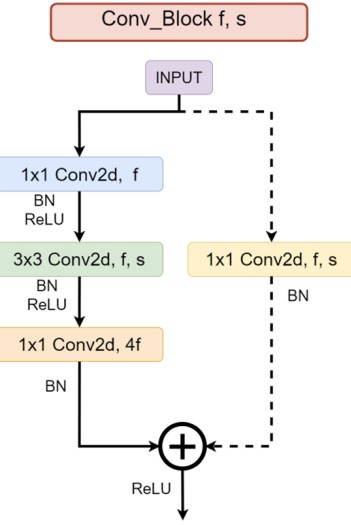

In [37]:
class Conv_Block(nn.Module):
    def __init__(self, in_channels, f, s):
        super(Conv_Block, self).__init__()
        """
        Conv_Block implementation
        
        Args:
            1. x : input
            2. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
            3. s (int): stride
        Returns the output of the conv block 
        """
        # Convolution layer 
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1)
        # Batch normalization in 2D 
        self.bn1 = nn.BatchNorm2d(f)
        # ReLU
        self.act1 = nn.ReLU()

        # Convolution layer 
        self.conv2 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 3, stride = s)
        # Batch normalization in 2D 
        self.bn2 = nn.BatchNorm2d(f)
        # ReLU
        self.act2 = nn.ReLU()

        # Convolution layer 
        self.conv3 = nn.Conv2d(in_channels = f, out_channels = 4*f, kernel_size = 1)
        # Batch normalization in 2D 
        self.bn3 = nn.BatchNorm2d(4*f)

        # Convolution layer 
        self.conv4 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 1, stride = s)
        # Batch normalization in 2D 
        self.bn4 = nn.BatchNorm2d(f)

        # ReLU 
        self.act = nn.ReLU()


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output1 = self.act1(self.bn1(self.conv1(x)))
        output1 = self.act2(self.bn2(self.conv2(output1)))
        output1 = self.bn3(self.conv3(output1))

        output2 = self.bn4(self.conv4(x))

        output = output1 + output2
        output = self.act(output)

        return output

<a name="subparagraph22"></a>
###  <font color='sienna'> II.2 -Implementation of Identity Block

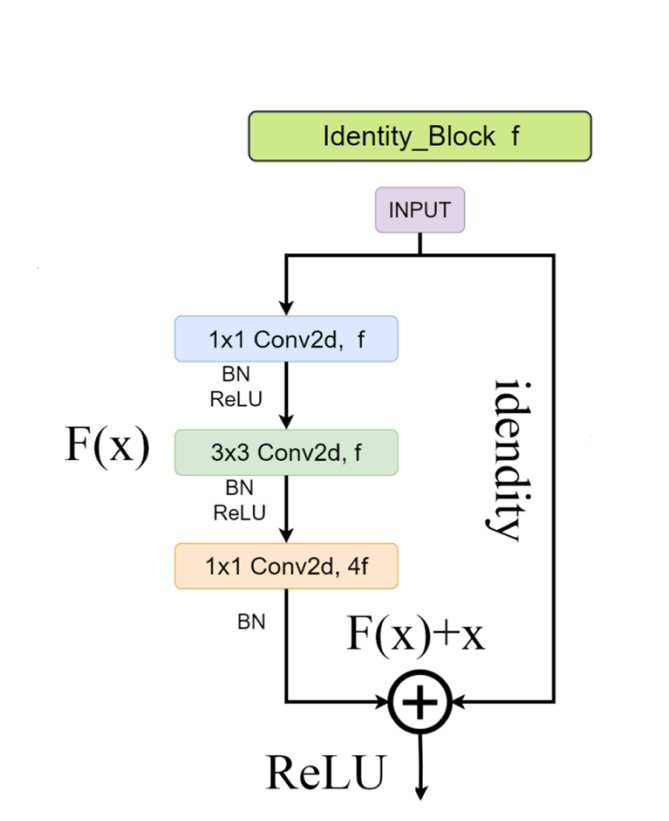

In [38]:
class Identity_Block(nn.Module):
    def __init__(self, in_channels, f):
        super(Identity_Block, self).__init__()
        """
        Identity_Block implementation
        
        Args:
            1. x : input
            2. in_channels (int) : Number of channels in the input.
            2. f (int): Number of channels in the output.
        Returns the output of the con block 
        """
        # Convolution layer 
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = f, kernel_size = 1)
        # Batch normalization in 2D 
        self.bn1 = nn.BatchNorm2d(f)
        # ReLU
        self.act1 = nn.ReLU()

        # Convolution layer 
        self.conv2 = nn.Conv2d(in_channels = f, out_channels = f, kernel_size = 3)
        # Batch normalization in 2D 
        self.bn2 = nn.BatchNorm2d(f)
        # ReLU
        self.act2 = nn.ReLU()

        # Convolution layer 
        self.conv3 = nn.Conv2d(in_channels = f, out_channels = 4*f, kernel_size = 1)
        # Batch normalization in 2D 
        self.bn3 = nn.BatchNorm2d(4*f)

        # ReLU 
        self.act = nn.ReLU()


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output = self.act1(self.bn1(self.conv1(x)))
        output = self.act2(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        output = output + x 
        output = self.act(output)
        return output

<a name="subparagraph23"></a>
###  <font color='sienna'> II.3 -Implementation of the ResNet block

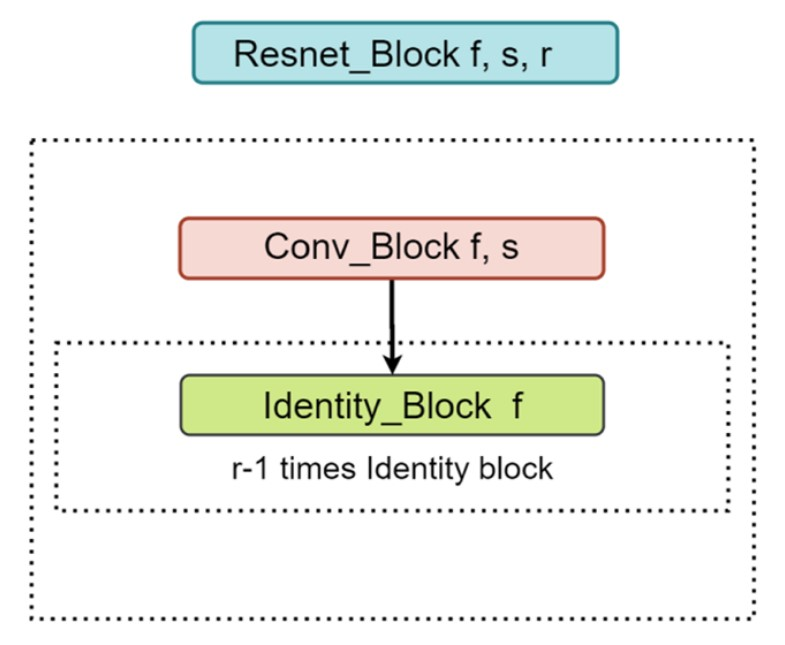

In [42]:
class ResNet_Block(nn.Module):
    def __init__(self,in_channels, f, s, r):
        super(ResNet_Block, self).__init__()
        """
        ResNet_Block implementation
        
        Args:
            1. x : input
            2. in_channels (int) : Number of channels in the input.
            3. f (int): Number of channels in the output.
            4. s (int) : stride 
            5. r (int) : Run r-1 times the identity block after the conv block 

        Returns the output of the ResNet block 
        """

        # Conv_Block 
        self.conv_block = nn.Sequential(*[Conv_Block(in_channels, f, s)])
        # Identity_Block 
        self.id_block = nn.Sequential(*[Identity_Block(in_channels, f) for _ in range(r-1)])
       

    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """

        output = self.id_block(self.conv_block(x))
        
        return output

<a name="subparagraph24"></a>
###  <font color='sienna'> II.4 -Implementation of the network COV19ResNet

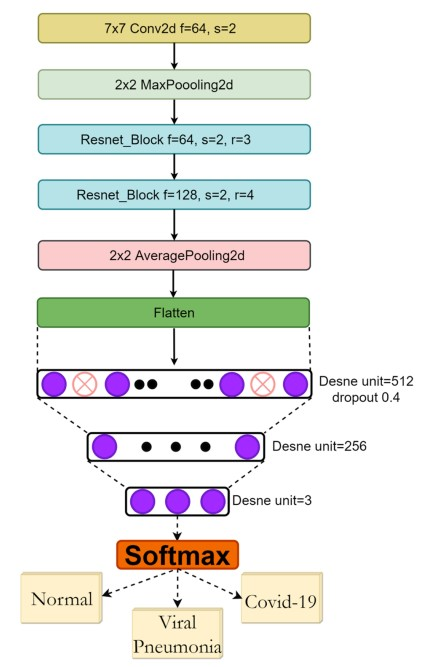

Here, we only output two neurons : Negative (to COVID 19) or Positive (to COVID 19). The detection of viral pneumonia isn't the focus of this project. 

In [46]:
class COV19_ResNet(nn.Module):
    def __init__(self, in_channels):
        super(COV19_ResNet, self).__init__()
        """
        COV19_ResNet implementation
        
        Args:
            1. x : input
            2. in_channels (int) : Number of channels in the input. (Should be 124x124x1)
        Returns the output of the con block 
        """
        # Convolution layer 
        self.res_conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 7, stride = 2)
        # MaxPooling layer 
        self.pool1 = nn.MaxPool2d(kernel_size = 2) # Output channels : (64/2)/2 = 16
        # First ResNet_Block 
        self.resNet1 = ResNet_Block(in_channels, f=64, s=2, r=3)
        # Second ResNet_Block
        self.resNet2 = ResNet_Block(in_channels, f=128, s=2, r=4)
        # 2x2 Average Pooling 2D 
        self.avg_pool = nn.AvgPool2d(kernel_size = 2)
        # Flatten 
        self.flat = nn.Flatten()
        # Desne unit = 512, dropout 0.4
        # Fully connected layer 
        self.fc1 = nn.Linear(32, 512) # TO CHECK OUTPUT SHAPE OF AVERAGE POOLING ??
        # Dropout 
        self.dropout = nn.Dropout2d(p =0.4)
        # Fully connected layer 
        self.fc2 = nn.Linear(512, 256)
        # Fully connected layer 
        self.fc3 = nn.Linear(256, 3)
        # Softmax 
        self.softmax = nn.Softmax() # dim Param ?? Or maybe put softmax in training function 



        


    def forward(self, x):
        """
        Feed-forward data 'x' through the module.
                
        Args:
            1. x (torch.FloatTensor)
            .
        Returns:
            1. output (torch.FloatTensor)
        """
        output = self.res_conv1(x) 
        output = self.pool1(output)
        output = self.avg_pool(self.resNet2(self.resNet1(output)))
        output = self.fc3(self.fc2(self.fc1(self.flat(output))))
        output = self.softmax(output)
        return output

In [20]:
# pip install easydict

In [70]:
# Configurations & Hyper-parameters

from easydict import EasyDict as edict

# set manual seeds 
torch.manual_seed(470)
torch.cuda.manual_seed(470)

args = edict()

# basic options 
args.name = 'main'                   # experiment name.
args.ckpt_dir = 'ckpts'              # checkpoint directory name.
args.ckpt_iter = 1000                # how frequently checkpoints are saved.
args.ckpt_reload = 'best'            # which checkpoint to re-load.
args.gpu = True                      # whether or not to use gpu. 

# network options
args.num_filters = 16                # number of output channels in the first nn.Conv2d module in MyNetwork.
args.block_type = 'mlp'              # type of block. ('mlp' | 'conv' | 'resPlain' | 'resBottleneck' | 'inception').
args.num_blocks = [5, 5, 5]          # number of blocks in each Layer.

# data options
args.dataroot = 'dataset/cifar10'    # where CIFAR10 images exist.
args.batch_size = 128                # number of mini-batch size.

# training options
args.lr = 0.1                        # learning rate.
args.epoch = 100                     # training epoch.

# tensorboard options
args.tensorboard = True              # whether or not to use tensorboard logging.
args.log_dir = 'logs'                # to which tensorboard logs will be saved.
args.log_iter = 100                  # how frequently logs are saved.

In [71]:
# Basic settings
device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

result_dir = Path('../results')
result_dir.mkdir(parents=True, exist_ok=True)

global_step = 0
best_accuracy = 0.

In [102]:
train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [88]:
def train_net(net, optimizer, scheduler, writer):
    global_step = 0
    best_accuracy = 0

    for epoch in range(args.epoch):
        # Here starts the train loop.
        net.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):

            global_step += 1

            #  Send `x` and `y` to either cpu or gpu using `device` variable. 
            x = x.to(device=device)
            y = y.to(device=device)
            
            # Feed `x` into the network, get an output, and keep it in a variable called `logit`. 
            logit = net(x)

            # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
            accuracy = (logit.argmax(1) == y).float().mean()

            # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
            loss = nn.CrossEntropyLoss()(logit, y)

            # flush out the previously computed gradient.
            optimizer.zero_grad()

            # backward the computed loss. 
            loss.backward()

            # update the network weights. 
            optimizer.step()

            if global_step % args.log_iter == 0 and writer is not None:
                # Log loss and accuracy values using `writer`. Use `global_step` as a timestamp for the log. 
                writer.add_scalar('train_loss', loss, global_step)
                writer.add_scalar('train_accuracy', accuracy, global_step)

            if global_step % args.ckpt_iter == 0: 
                # Save network weights in the directory specified by `ckpt_dir` directory. 
                torch.save(net.state_dict(), f'{ckpt_dir}/{global_step}.pt')

        # Here starts the test loop.
        net.eval()
        with torch.no_grad():
            test_loss = 0.
            test_accuracy = 0.
            test_num_data = 0.
            for batch_idx, (x, y) in enumerate(test_dataloader):
                # Send `x` and `y` to either cpu or gpu using `device` variable..
                x = x.to(device=device)
                y = y.to(device=device)

                # Feed `x` into the network, get an output, and keep it in a variable called `logit`.
                logit = net(x)

                # Compute loss using `logit` and `y`, and keep it in a variable called `loss`.
                loss = nn.CrossEntropyLoss()(logit, y)

                # Compute accuracy of this batch using `logit`, and keep it in a variable called 'accuracy'.
                accuracy = (logit.argmax(dim=1) == y).float().mean()

                test_loss += loss.item()*x.shape[0]
                test_accuracy += accuracy.item()*x.shape[0]
                test_num_data += x.shape[0]

            test_loss /= test_num_data
            test_accuracy /= test_num_data

            if writer is not None: 
                # Log loss and accuracy values using `writer`. Use `global_step` as a timestamp for the log. 
                writer.add_scalar('test_loss', test_loss, global_step)
                writer.add_scalar('test_accuracy', test_accuracy, global_step)

                # Just for checking progress
                print(f'Test result of epoch {epoch}/{args.epoch} || loss : {test_loss:.3f} acc : {test_accuracy:.3f} ')

                writer.flush()

            # Whenever `test_accuracy` is greater than `best_accuracy`, save network weights with the filename 'best.pt' in the directory specified by `ckpt_dir`.
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                torch.save(net.state_dict(), f'{ckpt_dir}/{block_type}_best.pt')
    
        scheduler.step()
    return best_accuracy


In [89]:
# Function for weight initialization.
def weight_init(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.constant_(m.weight, 1)
        torch.nn.init.constant_(m.bias, 0)

In [90]:
# Create directory name.
num_trial=0
parent_dir = result_dir / f'trial_{num_trial}'
while parent_dir.is_dir():
    num_trial = int(parent_dir.name.replace('trial_',''))
    parent_dir = result_dir / f'trial_{num_trial+1}'
print(f'Logs and ckpts will be saved in : {parent_dir}')



network = COV19_ResNet(args.num_filters).to(device)
network.apply(weight_init)


Logs and ckpts will be saved in : ..\results\trial_2


COV19_ResNet(
  (res_conv1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resNet1): ResNet_Block(
    (conv_block): Sequential(
      (0): Conv_Block(
        (conv1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv4): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2))
        (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
    )
    (id_block): Sequent

In [91]:
# pip install tensorboard

In [92]:
# Setup tensorboard.
if args.tensorboard:
    from torch.utils.tensorboard import SummaryWriter 
    %load_ext tensorboard
    %tensorboard --logdir "/{str(result_dir).replace('/gdrive/My Drive/', '')}"
else:
    writer = None

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 15736), started 0:11:09 ago. (Use '!kill 15736' to kill it.)

In [103]:
 # Define optimizer
optimizer = optim.SGD(network.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80], gamma=0.5)
        
# Create directories for logs and ckechpoints.
ckpt_dir = parent_dir / args.name / args.ckpt_dir
ckpt_dir.mkdir(parents=True, exist_ok=True)
log_dir = parent_dir / args.name / args.log_dir
log_dir.mkdir(parents=True, exist_ok=True)

# Create tensorboard writer,
if args.tensorboard: 
    writer = SummaryWriter(log_dir)

# Call the train & test function.
t1 = time.time()
accuracy = train_net(network, optimizer, scheduler, writer)
t = time.time()-t1
print(f'Best test accuracy : {accuracy:.3f} took {t:.3f} secs')


# Print final best accuracies of the models.
for key in final_accs.keys():
    print(f'Best accuracy of {key} = {final_accs[key]:.2f}%')


RuntimeError: stack expects each tensor to be equal size, but got [1, 512, 512] at entry 0 and [1, 1024, 1024] at entry 1